In [24]:
!pip install scikit-learn
!pip install seaborn


In [25]:
!pip install kneed


In [26]:
!pip install pyodbc


In [27]:
#Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
from sqlalchemy.exc import SQLAlchemyError
from sklearn.preprocessing import StandardScaler


In [28]:
from sqlalchemy import create_engine

# Database connection details
DRIVER_NAME = 'ODBC Driver 17 for SQL Server'
SERVER_NAME = 'LAPTOP-3R59J9VQ\\LOCALHOST1'  # Adjusted server name
DATABASE_NAME = 'CompanyX'  # Your database name

# Connection string for SQLAlchemy
conn_str = (
    f"mssql+pyodbc://@{SERVER_NAME}/{DATABASE_NAME}?driver={DRIVER_NAME}&trusted_connection=yes"
)

# Create engine
engine = create_engine(conn_str)

# Test the connection
try:
    with engine.connect() as connection:
        print("Connection successful!")
except Exception as e:
    print("Error connecting to the database:", e)



Connection successful!


In [29]:
# SQL query to fetch data
query = """
SELECT 
    p.Productname,
    p.ProductID,
    p.Category,
    f.Revenue,
    f.ROI,
    f.NetProfitMargin
FROM 
    Fact f
JOIN 
    DimProduct p ON f.ProductID = p.ProductID
"""

# Load data into a pandas DataFrame
data = pd.read_sql(query, engine)
print("Data loaded successfully.")

Data loaded successfully.


In [30]:
# Drop rows with missing values and check for duplicates
data = data.dropna().drop_duplicates()

In [31]:
# Function to preprocess data
def preprocess_category(data, category_name):
    category_data = data[data['Category'] == category_name].copy()
    if category_data.empty:
        print(f"Warning: No data found for category '{category_name}'. Skipping.")
        return None, None, None

    # Feature selection
    features = category_data[['Revenue', 'ROI', 'NetProfitMargin']].copy()

    # Outlier detection: Filter rows with extreme values
    revenue_threshold = features['Revenue'].quantile(0.99)  # 99th percentile
    features_filtered = features[features['Revenue'] < revenue_threshold]

    # Synchronize category_data to match filtered features
    category_data = category_data.loc[features_filtered.index]

    # Scaling using MinMaxScaler
    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(features_filtered)

    return category_data, features_scaled, scaler

In [32]:
def find_optimal_clusters(features, max_clusters=15):
    # Scale the features for better clustering
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    inertia = []
    silhouette_scores = []
    
    # Calculate inertia and silhouette scores
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(scaled_features)
        inertia.append(kmeans.inertia_)
        silhouette = silhouette_score(scaled_features, labels)
        silhouette_scores.append(silhouette)
    
    # Find knee point for optimal K
    kneedle = KneeLocator(range(2, max_clusters + 1), inertia, curve="convex", direction="decreasing")
    optimal_k = kneedle.knee

    # Plot Elbow Curve and Silhouette Scores
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Elbow Curve
    ax[0].plot(range(2, max_clusters + 1), inertia, 'o--', label='Inertia')
    ax[0].axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal K: {optimal_k}')
    ax[0].set_title('Elbow Method')
    ax[0].set_xlabel('Number of Clusters')
    ax[0].set_ylabel('Inertia')
    ax[0].legend()

    # Silhouette Scores
    ax[1].plot(range(2, max_clusters + 1), silhouette_scores, 'o--', color='green', label='Silhouette Score')
    ax[1].axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal K: {optimal_k}')
    ax[1].set_title('Silhouette Scores for Clusters')
    ax[1].set_xlabel('Number of Clusters')
    ax[1].set_ylabel('Silhouette Score')
    ax[1].legend()

    plt.show()
    
    return optimal_k

In [33]:
# Perform clustering and visualize
def perform_clustering(data, category_name, n_clusters=None):
    category_data, features_scaled, scaler = preprocess_category(data, category_name)
    if category_data is None or features_scaled is None:
        return None

    # Determine number of clusters if not provided
    if n_clusters is None:
        n_clusters = find_optimal_clusters(features_scaled)
    
    # K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    category_data['Cluster'] = kmeans.fit_predict(features_scaled)

    # Retrieve centroids
    centroids = scaler.inverse_transform(kmeans.cluster_centers_)

    # Visualization
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=category_data, x='Revenue', y='ROI', 
                    hue='Cluster', palette='viridis', s=100)
    
    # Plot centroids
    plt.scatter(centroids[:, 0], centroids[:, 1], 
                c='red', s=300, marker='X', label='Centroids')
    plt.title(f'Clustering Results for {category_name} Category')
    plt.xlabel('Revenue')
    plt.ylabel('Return on Investment')
    plt.legend(title='Cluster')
    plt.show()
    
    # Display cluster statistics
    cluster_summary = category_data.groupby('Cluster')[['Revenue', 'ROI', 'NetProfitMargin']].mean()
    print(f"Cluster Summary for {category_name}:")
    print(cluster_summary)

    return category_data

In [34]:
def save_to_sql_server(dataframe, table_name, engine):

    try:
        # Fetch existing ProductIDs from the table to avoid duplication
        existing_query = f"SELECT ProductID FROM {table_name}"
        try:
            existing_data = pd.read_sql(existing_query, engine)
            existing_ids = existing_data['ProductID'].unique()
        except Exception as e:
            # Table does not exist, so no existing data
            existing_ids = []

        # Filter out rows that already exist in the table
        new_data = dataframe[~dataframe['ProductID'].isin(existing_ids)]

        if new_data.empty:
            print(f"No new data to save for table '{table_name}'.")
        else:
            # Save new data to SQL Server
            new_data.to_sql(name=table_name, con=engine, if_exists='append', index=False)
            print(f"Successfully saved {len(new_data)} new records to table '{table_name}'.")
    except SQLAlchemyError as e:
        print(f"Error saving data to table '{table_name}': {e}")

In [35]:
# Example: Preprocess the categories and perform clustering   
bikes_data, bikes_features, bikes_scaler = preprocess_category(data, 'Bikes')
clothing_data, clothing_features, clothing_scaler = preprocess_category(data, 'Clothing')
components_data, components_features, components_scaler = preprocess_category(data, 'Components')
accessories_data, accessories_features, accessories_scaler = preprocess_category(data, 'Accessories')


print("Bike data: ")
print(bikes_data.describe())
print("Clothings data: ")
print(clothing_data.describe())
print("Components data: ")
print(components_data.describe())
print("Accessories data: ")
print(accessories_data.describe())

Bike data: 
         ProductID       Revenue          ROI  NetProfitMargin
count  1023.000000   1023.000000  1023.000000      1023.000000
mean    852.427175   2931.810303    -0.127390        -7.262219
std      96.061544   2742.662882     0.581569        23.511521
min     749.000000    112.990000    -4.220000      -172.760000
25%     777.000000    939.580000    -0.280000        -6.060000
50%     793.000000   1907.250000    -0.100000        -3.600000
75%     965.500000   4079.980000     0.090000         6.260000
max     999.000000  13215.650000     2.580000         9.070000
Clothings data: 
        ProductID     Revenue         ROI  NetProfitMargin
count  210.000000  210.000000  210.000000       210.000000
mean   819.400000  186.934095    0.851238         9.290810
std     69.946131  166.133103    2.358561        31.918445
min    709.000000    5.180000   -9.590000       -45.600000
25%    715.000000   57.680000   -0.430000       -28.330000
50%    859.000000  144.085000    0.510000        3


--- Clustering for Bikes Category ---


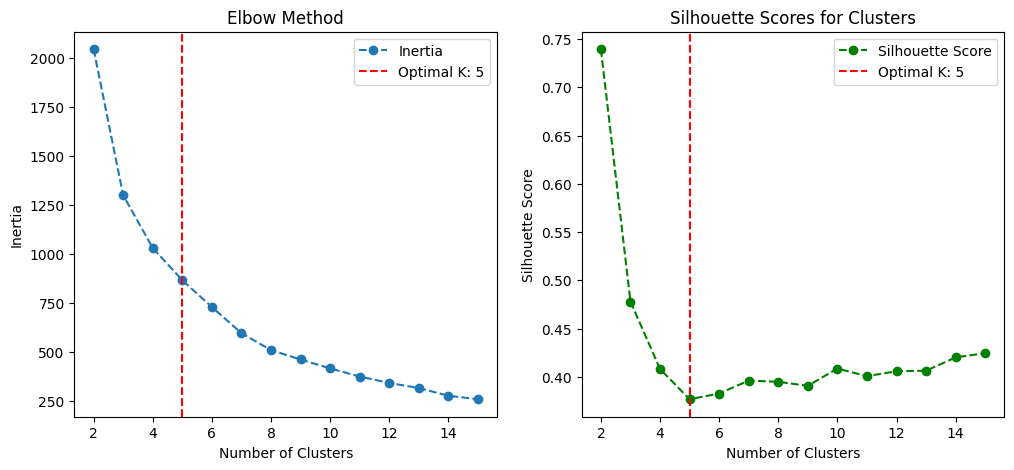

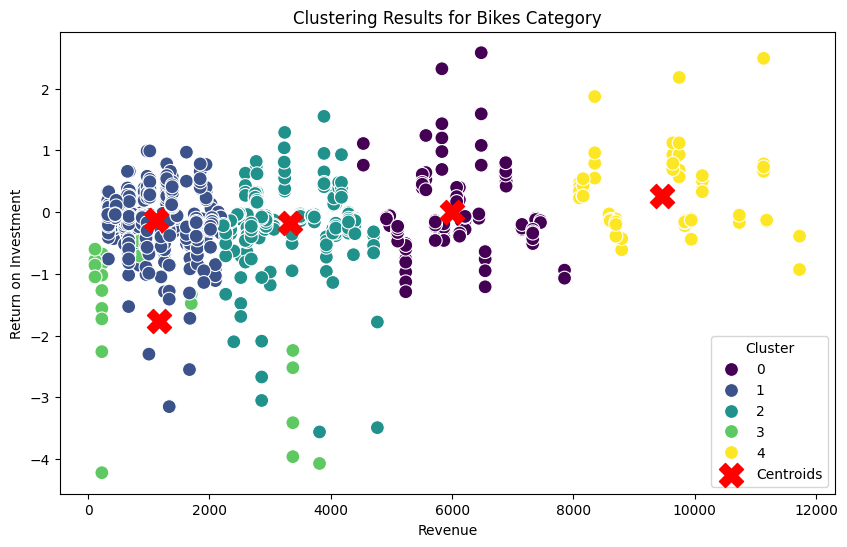

Cluster Summary for Bikes:
             Revenue       ROI  NetProfitMargin
Cluster                                        
0        6005.939298  0.006053        -2.092456
1        1116.674927 -0.121460        -6.189708
2        3322.422597 -0.171512        -3.836667
3        1175.219524 -1.764286      -142.717619
4        9458.583529  0.264412         2.833529


In [36]:
# Find optimal clusters
print(f"\n--- Clustering for Bikes Category ---")
# Apply clustering with a predefined number of clusters 
bikes_clustered_data = perform_clustering(bikes_data,'Bikes')


--- Clustering for Components Category ---


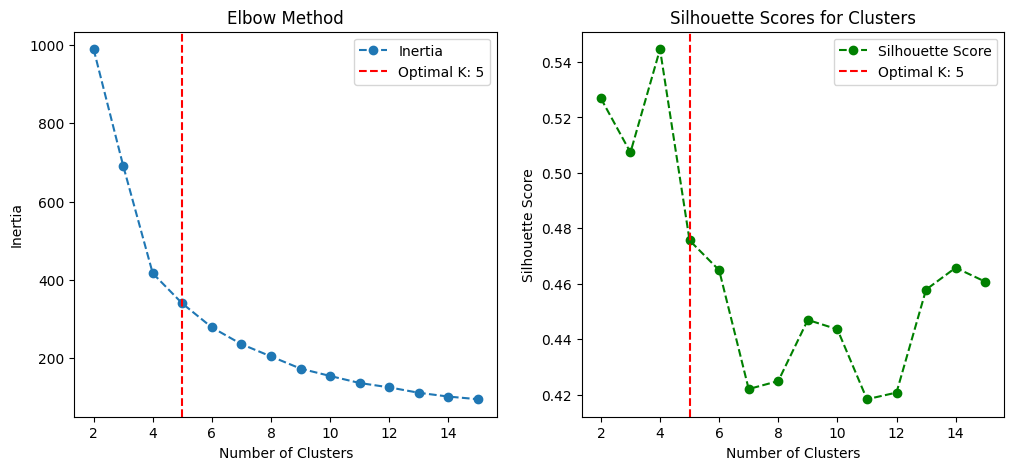

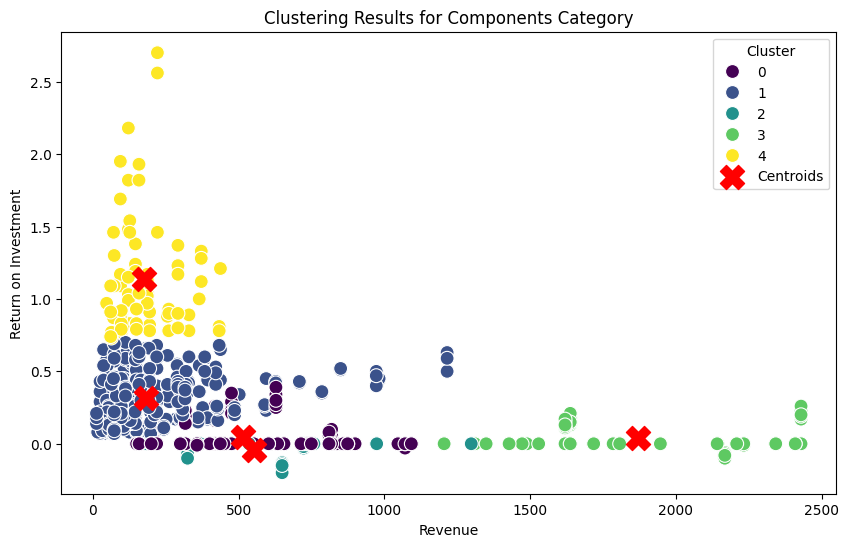

Cluster Summary for Components:
             Revenue       ROI  NetProfitMargin
Cluster                                        
0         515.763310  0.044577         6.190211
1         180.505041  0.313939        25.115069
2         551.011200 -0.046000       -11.234400
3        1869.326000  0.042600         2.613400
4         176.686528  1.138472        25.990278


In [37]:
print(f"\n--- Clustering for Components Category ---")
# Apply clustering with a predefined number of clusters 
components_clustered_data = perform_clustering(components_data,'Components')


--- Clustering for Clothing Category ---


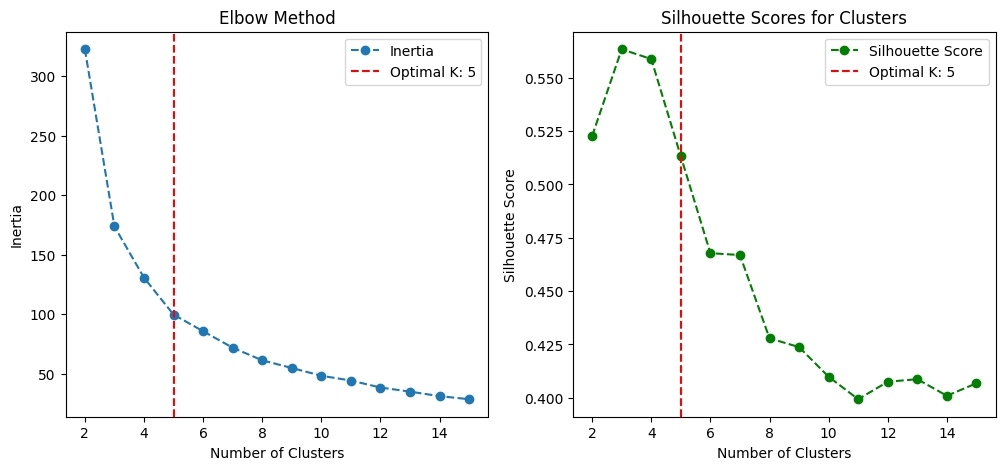

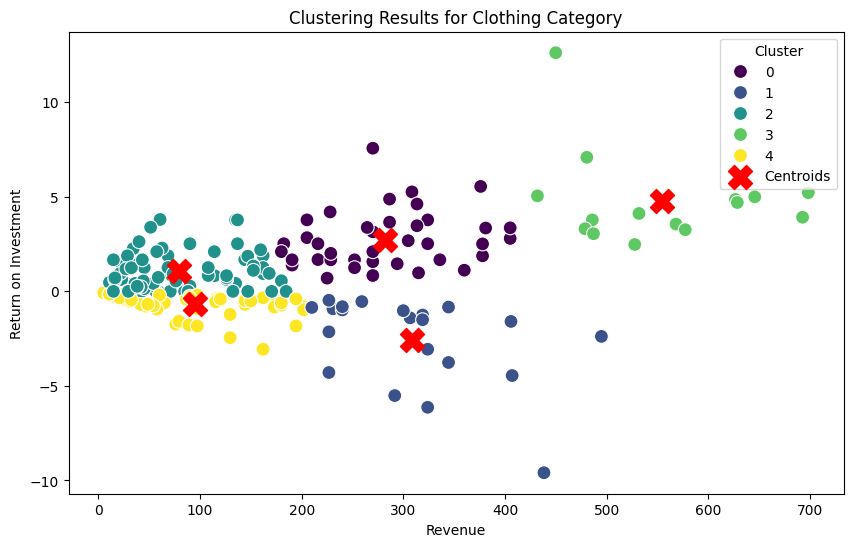

Cluster Summary for Clothing:
            Revenue       ROI  NetProfitMargin
Cluster                                       
0        281.651053  2.741053        32.749211
1        308.525238 -2.546190       -31.066667
2         79.587067  1.061067        35.313200
3        554.155333  4.801333        29.413333
4         95.196034 -0.655690       -31.494483


In [38]:
print(f"\n--- Clustering for Clothing Category ---")
# Apply clustering with a predefined number of clusters 
clothing_clustered_data = perform_clustering(clothing_data,'Clothing')


--- Clustering for Accessories Category ---


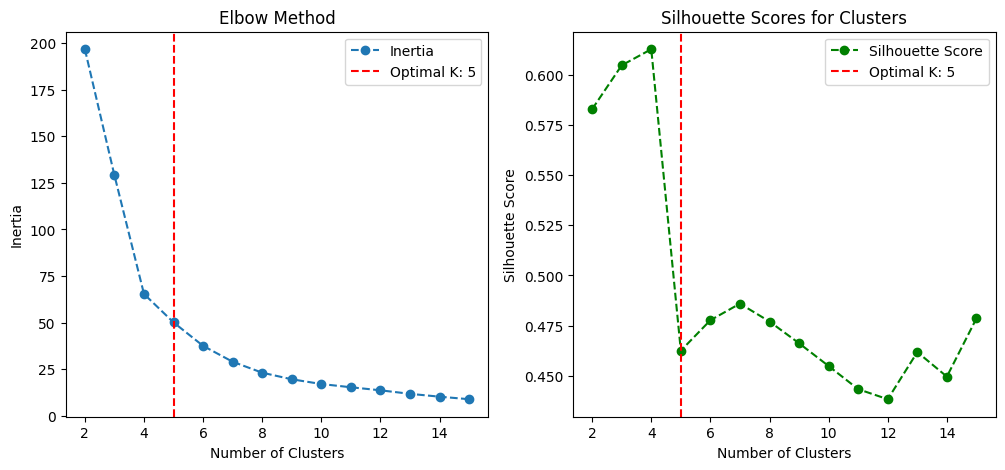

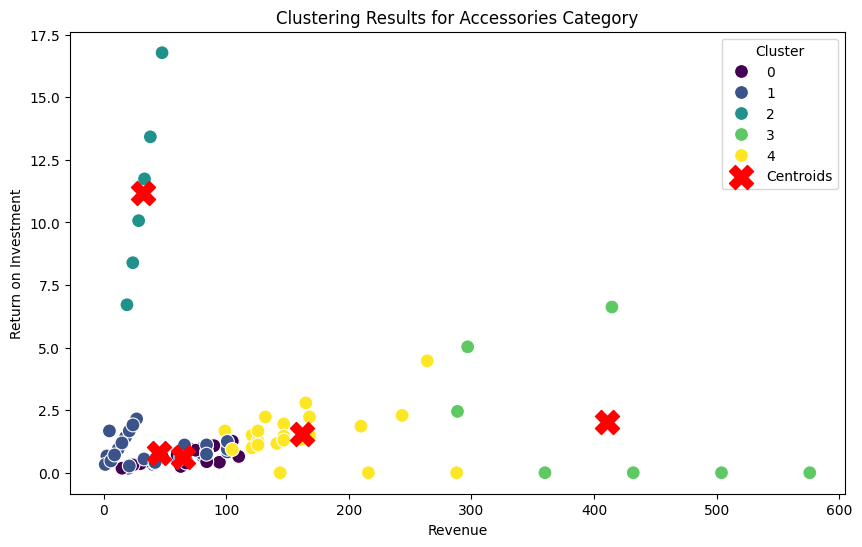

Cluster Summary for Accessories:
            Revenue        ROI  NetProfitMargin
Cluster                                        
0         64.744211   0.628421        27.548947
1         45.207027   0.799189        36.650541
2         31.800000  11.185000        37.660000
3        410.317143   2.014286        36.542857
4        162.088636   1.531818        37.109545


In [39]:
print(f"\n--- Clustering for Accessories Category ---")
# Apply clustering with a predefined number of clusters 
accessories_clustered_data = perform_clustering(accessories_data,'Accessories')

In [40]:
save_to_sql_server(bikes_clustered_data, 'KMean_Bikes_Clusters', engine)

Successfully saved 1009 new records to table 'KMean_Bikes_Clusters'.


In [41]:
save_to_sql_server(accessories_clustered_data, 'KMean_Accessories_Clusters', engine)

Successfully saved 91 new records to table 'KMean_Accessories_Clusters'.


In [42]:
save_to_sql_server(components_clustered_data, 'KMean_Components_Clusters', engine)

Successfully saved 652 new records to table 'KMean_Components_Clusters'.


In [43]:
save_to_sql_server(clothing_clustered_data, 'KMean_Clothing_Clusters', engine)

Successfully saved 207 new records to table 'KMean_Clothing_Clusters'.
